#Training the Model

#Loading Libraries and Dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

In [2]:
import librosa as lb

In [8]:
#Loading Dataset
files_df=pd.read_csv("D:\\Downloads\\Lung-Disease-Audio-Classification\\files_df.csv")

In [9]:
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.364,3.250,0.0,1.0,103,mc,103_2b2_Ar_mc_LittC2SE
1,3.250,6.636,0.0,0.0,103,mc,103_2b2_Ar_mc_LittC2SE
2,6.636,11.179,0.0,1.0,103,mc,103_2b2_Ar_mc_LittC2SE
3,11.179,14.250,0.0,1.0,103,mc,103_2b2_Ar_mc_LittC2SE
4,14.250,16.993,0.0,1.0,103,mc,103_2b2_Ar_mc_LittC2SE


Playing with various spectral Features

[Text(0.5, 1.0, 'MFCC')]

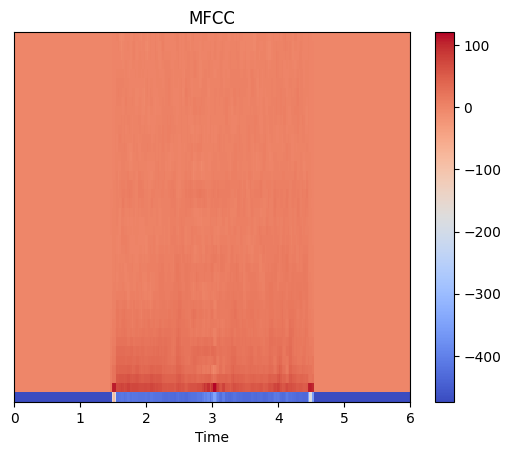

In [10]:
path='D:\\Downloads\\Lung-Disease-Audio-Classification\\processed_audio_files\\'

import librosa.display
file=path +files_df.iloc[3].filename + '.wav'
sound,sample_rate=lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')


In [11]:
S = np.abs(librosa.stft(y=sound))
S

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

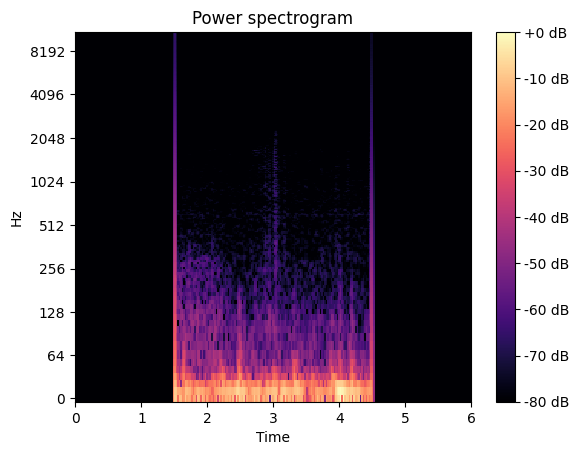

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                        ref=np.max),
                                y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

Adding a column for final outcome which will later be label encoded

In [13]:
files_df['weezels'] = files_df['weezels'].astype(int)
files_df['crackles'] = files_df['crackles'].astype(int)

In [14]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6110 non-null   float64
 1   end       6110 non-null   float64
 2   crackles  6110 non-null   int32  
 3   weezels   6110 non-null   int32  
 4   pid       6110 non-null   int64  
 5   mode      6110 non-null   object 
 6   filename  6110 non-null   object 
dtypes: float64(2), int32(2), int64(1), object(2)
memory usage: 286.5+ KB


In [15]:
def categorise(row):
  if row['weezels']==0 and row['crackles']==0 :
    return 'normal'
  elif row['weezels']==1 and row['crackles']==0 :
    return 'weezels'
  elif row['weezels']==0 and row['crackles']==1 :
    return 'crackles'
  else:
    return 'both'

In [16]:
files_df['outcome'] = files_df.apply(lambda row: categorise(row), axis=1)

In [17]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6110 non-null   float64
 1   end       6110 non-null   float64
 2   crackles  6110 non-null   int32  
 3   weezels   6110 non-null   int32  
 4   pid       6110 non-null   int64  
 5   mode      6110 non-null   object 
 6   filename  6110 non-null   object 
 7   outcome   6110 non-null   object 
dtypes: float64(2), int32(2), int64(1), object(3)
memory usage: 334.3+ KB


Dividing the data into train and testing(validation datset)

In [18]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(files_df,files_df.outcome,stratify=files_df.outcome,random_state=42,test_size=0.25)

In [19]:
Xtrain.head()

,start,end,crackles,weezels,pid,mode,filename,outcome
5773,16.869,18.821,0,0,216,sc,216_1b1_Al_sc_Meditron,normal
696,8.236,12.064,0,1,122,mc,122_2b2_Tc_mc_LittC2SE,weezels
1668,3.715,7.855,1,0,138,mc,138_1p2_Lr_mc_AKGC417L,crackles
1022,14.875,16.946,1,0,130,mc,130_2b3_Ll_mc_AKGC417L,crackles
709,0.036,4.079,0,0,122,mc,122_2b3_Tc_mc_LittC2SE,normal


In [20]:
ytrain=Xtrain.outcome
yval=Xval.outcome

Performing label encoding

In [21]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [22]:
#checking the labels assigned to each category
list(le.inverse_transform([0, 1, 2, 3]))

['both', 'crackles', 'normal', 'weezels']

#Feature Extraction

In [23]:
#function to get various features : MFCC,STFt,MelSpectrogram
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [24]:
#Creating Feature array for each different transform for validation set
root='D:\\Downloads\\Lung-Disease-Audio-Classification\\processed_audio_files\\'
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xval.iterrows():
    path=root + row['filename'] + '.wav'
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [25]:
#Creating Feature array for each different transform for test set
root='D:\\Downloads\\Lung-Disease-Audio-Classification\\processed_audio_files\\'
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xtrain.iterrows():
    path=root + row['filename'] + '.wav'
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

#Training

##Model Architecture:
The model is based in m5 architecture of CNN. Here the seperate features are trained on three sperate CNNs and the results are in turn put through another neural network which finally classifies the audios as onr of four categories: **both ,weezels ,crackles ,normal**.


---


Each layers input is an array of size equal to the size of the transformation performed by librosa library. The outputs of these three layers is then given to final network which inturn givers 4 outputs which are the estimated likeliness of an audio sample belonging to a particular class

In [26]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [27]:
#mfcc CNN block
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput") #input size (20,259,1) as array shape of mfcc is (20,259)
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [28]:
mfcc_model.summary()

Model: "mfccModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mfccInput (InputLayer)               │ (None, 20, 259, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 20, 87, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 20, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 11, 96)           │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 11, 96)           │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 5, 11, 96)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 5, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 5, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,560 (369.38 KB)

 Trainable params: 93,920 (366.88 KB)

 Non-trainable params: 640 (2.50 KB)

In [29]:
#STFT CNN block
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput") #input size (12,259,1) as array shape of cstft is (12,259)
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [30]:
croma_model.summary()

Model: "cromaModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ cromaInput (InputLayer)              │ (None, 12, 259, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 87, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 12, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 43, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 22, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 22, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 6, 22, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 11, 128)          │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 11, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 3, 11, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,120 (207.50 KB)

 Trainable params: 52,672 (205.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [31]:
#mel spectogram input block
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput") #input size (128,259,1) as array shape of melSpectogram is (128,259)
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [32]:
mSpec_model.summary()

Model: "mSpecModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mSpecInput (InputLayer)              │ (None, 128, 259, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 87, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 11, 96)           │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 11, 96)           │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 8, 11, 96)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 5, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 5, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 4, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 4, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,560 (369.38 KB)

 Trainable params: 93,920 (366.88 KB)

 Non-trainable params: 640 (2.50 KB)

In [33]:
#combining the 3 models
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(4,activation='softmax')(hidden) # 4 classes so 4 number of outputs

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [34]:
net.summary()

Model: "Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc (InputLayer)             │ (None, 20, 259, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ croma (InputLayer)            │ (None, 12, 259, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mspec (InputLayer)            │ (None, 128, 259, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mfccModel (Functional)        │ (None, 128)               │          94,560 │ mfcc[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cromaModel (Functional)       │ (None, 128)               │          53,120 │ croma[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mSpecModel (Functional)       │ (None, 128)               │          94,560 │ mspec[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 384)               │               0 │ mfccModel[0][0],           │
│                               │                           │                 │ cromaModel[0][0],          │
│                               │                           │                 │ mSpecModel[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 50)                │          19,250 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 50)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 25)                │           1,275 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 25)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 4)                 │             104 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 262,869 (1.00 MB)

 Trainable params: 261,141 (1020.08 KB)

 Non-trainable params: 1,728 (6.75 KB)

In [37]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

AttributeError: module 'keras.api.backend' has no attribute 'set_value'

In [38]:
# import tensorflow.keras.backend as K
# net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
# K.set_value(net.optimizer.learning_rate, 0.001)

import tensorflow as tf
from tensorflow.keras.optimizers import Nadam

# Instantiate the Nadam optimizer with a default learning rate
optimizer = Nadam(learning_rate=0.001)

# Compile the model using the optimizer
net.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# To modify the learning rate after compilation:
net.optimizer.learning_rate.assign(0.001)



<tf.Tensor: shape=(), dtype=float32, numpy=0.0010000000474974513>

In [40]:
mfcc_train = mfcc_train[:, :, :, np.newaxis]  # Shape becomes (batch_size, 20, 259, 1)
cstft_train = cstft_train[:, :, :, np.newaxis]  # Shape becomes (batch_size, 12, 259, 1)
mSpec_train = mSpec_train[:, :, :, np.newaxis]  # Shape becomes (batch_size, 128, 259, 1)

# Validation data
mfcc_val = mfcc_val[:, :, :, np.newaxis]  # Shape becomes (batch_size, 20, 259, 1)
cstft_val = cstft_val[:, :, :, np.newaxis]  # Shape becomes (batch_size, 12, 259, 1)
mSpec_val = mSpec_val[:, :, :, np.newaxis]  # Shape becomes (batch_size, 128, 259, 1)

In [42]:
mfcc_train = np.pad(mfcc_train, ((0, 2), (0, 0), (0, 0), (0, 0)), 'constant')

In [43]:
# Example: Truncate an array from (6, 2) to (4, 2)
mfcc_train = mfcc_train[:4, :, :, :]

In [44]:
# Example: Truncate an array from (6, 2) to (4, 2)
mfcc_train = mfcc_train[:4, :, :, :]

In [45]:
# Reshape each input to add a channel dimension
# Training data
mfcc_train = mfcc_train[:, :, :, np.newaxis]  # Shape becomes (batch_size, 20, 259, 1)
cstft_train = cstft_train[:, :, :, np.newaxis]  # Shape becomes (batch_size, 12, 259, 1)
mSpec_train = mSpec_train[:, :, :, np.newaxis]  # Shape becomes (batch_size, 128, 259, 1)

# Validation data
mfcc_val = mfcc_val[:, :, :, np.newaxis]  # Shape becomes (batch_size, 20, 259, 1)
cstft_val = cstft_val[:, :, :, np.newaxis]  # Shape becomes (batch_size, 12, 259, 1)
mSpec_val = mSpec_val[:, :, :, np.newaxis]  # Shape becomes (batch_size, 128, 259, 1)

In [47]:
print("mfcc_train shape:", mfcc_train.shape)
print("cstft_train shape:", cstft_train.shape)
print("mSpec_train shape:", mSpec_train.shape)
print("ytrain shape:", ytrain.shape)

mfcc_train shape: (4, 20, 259, 1, 1)
cstft_train shape: (4582, 12, 259, 1, 1)
mSpec_train shape: (4582, 128, 259, 1, 1)
ytrain shape: (4582,)


In [48]:
mfcc_train = np.tile(mfcc_train, (4582 // 4 + 1, 1, 1, 1, 1))[:4582]

In [49]:
#Training the Model
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "mfccModel" is incompatible with the layer: expected shape=(None, 20, 259, 1), found shape=(None, 12, 259)[0m

Arguments received by Functional.call():
  • inputs={'mfcc': 'tf.Tensor(shape=(None, 20, 259, 1, 1), dtype=float32)', 'croma': 'tf.Tensor(shape=(None, 12, 259, 1, 1), dtype=float32)', 'mspec': 'tf.Tensor(shape=(None, 128, 259, 1, 1), dtype=float32)'}
  • training=True
  • mask={'mfcc': 'None', 'croma': 'None', 'mspec': 'None'}

In [126]:
# Step 1: Add channel dimension
mfcc_val = np.expand_dims(mfcc_val, axis=-1)  # Adding the channel dimension
print(mfcc_val.shape)  # Check shape

# Step 2: Pad frequency bins (from 12 to 20)
mfcc_val = np.pad(mfcc_val, ((0, 0), (0, 8), (0, 0), (0, 0)), mode='constant')  # Padding to 20 bins
print(mfcc_val.shape)  # Should now be (batch_size, 20, 259, 1)


(1528, 20, 259, 1, 1, 1)


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,2)  and requested shape (6,2)

In [124]:
net.evaluate({
    "mfcc": mfcc_val,  # Shape should be (num_samples, 20, 259, 1)
    "croma": cstft_val,  # Shape should be (num_samples, 12, 259, 1)
    "mspec": mSpec_val,  # Shape should be (num_samples, 128, 259, 1)
}, yval)

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "mfccModel" is incompatible with the layer: expected shape=(None, 20, 259, 1), found shape=(None, 12, 259)[0m

Arguments received by Functional.call():
  • inputs={'mfcc': 'tf.Tensor(shape=(None, 20, 259, 1), dtype=float32)', 'croma': 'tf.Tensor(shape=(None, 12, 259, 1), dtype=float32)', 'mspec': 'tf.Tensor(shape=(None, 128, 259, 1), dtype=float32)'}
  • training=False
  • mask={'mfcc': 'None', 'croma': 'None', 'mspec': 'None'}

In [123]:
from tensorflow.keras.layers import Reshape, ZeroPadding2D

# Reshape or pad inputs to ensure the same size along the second axis
input_mfcc = Input(shape=(20, 259, 1), name='mfcc')
input_croma = Input(shape=(12, 259, 1), name='croma')
input_mspec = Input(shape=(128, 259, 1), name='mspec')

# Reshape or pad the inputs to match dimensions (using padding or resizing)
x1 = ZeroPadding2D(padding=((4, 0), (0, 0)))(input_mfcc)  # Adjust padding as needed
x2 = ZeroPadding2D(padding=((4, 0), (0, 0)))(input_croma)
x3 = input_mspec  # No padding for this one, as its shape is already the largest

# Now concatenate the reshaped inputs
merged = Concatenate()([x1, x2, x3])

# Rest of the model...



ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 24, 259, 1), (None, 16, 259, 1), (None, 128, 259, 1)]

In [118]:
#Training the Model
history = net.fit(
    {"mfcc": mfcc_train, "croma": cstft_train, "mspec": mSpec_train},
    ytrain,
    validation_data=({"mfcc": mfcc_val, "croma": cstft_val, "mspec": mSpec_val}, yval),
    epochs=100,
    verbose=0,
    callbacks=my_callbacks
)

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "mfccModel" is incompatible with the layer: expected shape=(None, 20, 259, 1), found shape=(None, 12, 259)[0m

Arguments received by Functional.call():
  • inputs={'mfcc': 'tf.Tensor(shape=(None, 20, 259, 1), dtype=float32)', 'croma': 'tf.Tensor(shape=(None, 12, 259, 1), dtype=float32)', 'mspec': 'tf.Tensor(shape=(None, 128, 259, 1), dtype=float32)'}
  • training=True
  • mask={'mfcc': 'None', 'croma': 'None', 'mspec': 'None'}

In [88]:
# keras.utils.plot_model(net, "net.png", show_shapes=True)

In [89]:
from tensorflow.keras.optimizers import Nadam

# First, compile the model with the Nadam optimizer
net.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])

# Set the learning rate directly
net.optimizer.learning_rate = 0.001


In [50]:
# from keras import backend as K
# net.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])
# K.set_value(net.optimizer.learning_rate, 0.001)

In [76]:
from tensorflow.keras.layers import Input, Conv2D, Dense, concatenate
from tensorflow.keras.layers import Input

In [95]:
net.compile(optimizer='adam',
            loss='categorical_crossentropy',  # For multi-class classification
            metrics=['accuracy'])

In [100]:
from tensorflow.keras.layers import Input, Conv2D, Dense, concatenate, ZeroPadding2D
import tensorflow as tf

# Define the input layers for each type of feature
mfcc_input = Input(shape=(18, 257, 32), name="mfcc")
croma_input = Input(shape=(10, 257, 32), name="croma")
mspec_input = Input(shape=(126, 257, 32), name="mspec")

# Apply Conv2D layers to process each input
x_mfcc = Conv2D(32, (3, 3), activation='relu')(mfcc_input)
x_croma = Conv2D(32, (3, 3), activation='relu')(croma_input)
x_mspec = Conv2D(32, (3, 3), activation='relu')(mspec_input)

# Pad the inputs to make the heights the same (padding to the largest height, which is 126)
x_mfcc_padded = ZeroPadding2D(padding=((108, 0), (0, 0)))(x_mfcc)  # Padding height to 126
x_croma_padded = ZeroPadding2D(padding=((116, 0), (0, 0)))(x_croma)  # Padding height to 126
x_mspec_padded = x_mspec  # Already 126, no padding needed

# Concatenate the tensors along the channels axis (last axis)
x = concatenate([x_mfcc_padded, x_croma_padded, x_mspec_padded])

# Output layer (for binary classification)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.Model(inputs=[mfcc_input, croma_input, mspec_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the inputs
history = model.fit(
    {"mfcc": mfcc_train, "croma": cstft_train, "mspec": mSpec_train},
    ytrain,
    validation_data=({"mfcc": mfcc_val, "croma": cstft_val, "mspec": mSpec_val}, yval),
    epochs=100,
    verbose=0,
    callbacks=my_callbacks
)


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 18, 257, 32), found shape=(None, 20, 259)

In [96]:
#Training the Model
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)



ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "mfccModel" is incompatible with the layer: expected shape=(None, 20, 259, 1), found shape=(None, 12, 259)[0m

Arguments received by Functional.call():
  • inputs={'mfcc': 'tf.Tensor(shape=(None, 20, 259, 1), dtype=float32)', 'croma': 'tf.Tensor(shape=(None, 12, 259, 1), dtype=float32)', 'mspec': 'tf.Tensor(shape=(None, 128, 259, 1), dtype=float32)'}
  • training=True
  • mask={'mfcc': 'None', 'croma': 'None', 'mspec': 'None'}

In [105]:
from tensorflow.keras import layers

conv_filters = 32  # Adjust these values as needed
kernel_size = (3, 3)

inputs = {
    "mfcc": layers.Input(shape=(20, 259, 1)),
    "croma": layers.Input(shape=(12, 259, 1)),
    "mspec": layers.Input(shape=(128, 259, 1)),
}

# Processing for mfcc
processed_mfcc = layers.Conv2D(conv_filters, kernel_size, activation="relu")(inputs["mfcc"])
processed_mfcc = layers.MaxPooling2D((2, 2))(processed_mfcc)  # Adjust layers as needed

# Processing for croma
processed_croma = layers.Dense(units=64, activation="relu")(inputs["croma"])

# Processing for mspec
processed_mspec = layers.Conv2D(conv_filters, kernel_size, activation="relu")(inputs["mspec"])
processed_mspec = layers.MaxPooling2D((2, 2))(processed_mspec)  # Adjust layers as needed

# Combine processed features
combined_features = tf.concat([processed_mfcc, processed_croma, processed_mspec], axis=-1)

# Rest of your model definition
outputs = layers.Dense(units=10, activation="softmax")(combined_features)  # Or your desired output layer

model = tf.keras.Model(inputs=inputs, outputs=outputs)

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [102]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "mfccModel" is incompatible with the layer: expected shape=(None, 20, 259, 1), found shape=(None, 12, 259)[0m

Arguments received by Functional.call():
  • inputs={'mfcc': 'tf.Tensor(shape=(None, 20, 259, 1), dtype=float32)', 'croma': 'tf.Tensor(shape=(None, 12, 259, 1), dtype=float32)', 'mspec': 'tf.Tensor(shape=(None, 128, 259, 1), dtype=float32)'}
  • training=False
  • mask={'mfcc': 'None', 'croma': 'None', 'mspec': 'None'}

In [ ]:
#saving the model for future use
net.save('/content/drive/MyDrive/Mosaic23/models/MosaicModel.h5')

#Loading Model

In [ ]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Mosaic23/models/MosaicModel.h5")

In [ ]:
path='/content/drive/MyDrive/Mosaic23/processed_audio_files/195_1b1_Ar_sc_Litt3200_0.wav'

In [ ]:
mfcc,cstft,mSpec,tempogram=[],[],[],[]


a,b,c=getFeatures(path)
mfcc.append(a)
cstft.append(b)
mSpec.append(c)
    
mfcc_test=np.array(mfcc)
cstft_test=np.array(cstft)
mSpec_test=np.array(mSpec)

In [ ]:
predictions=reconstructed_model.predict({"mfcc":mfcc_test,"croma":cstft_test,"mspec":mSpec_test})

1/1 [==============================] - 0s 396ms/step


In [ ]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[3]


In [ ]:
def return_output(classes):
  if(classes[0]==0) :
    return 'both'
  if(classes[0]==1) :
    return 'crackles'
  if(classes[0]==2):
     return 'normal'
  if(classes[0]==3) :
    return 'weezels'

In [ ]:
print(return_output(classes))

weezels
